In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import torch
from tqdm import tqdm
from src.models import OldSpaceNet

In [2]:

train_steps = 5000

n_in = 2 # 2 position inputs 
n_out = 128 # no. of spatial representations
bs = 128 # batch size 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = OldSpaceNet(n_in, n_out, scale = 0.15, device = device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype= torch.float32, device=device)
    loss = model.train_step(x = r, y = r, optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.014320: 100%|██████████| 5000/5000 [00:05<00:00, 958.13it/s] 


In [3]:
# evaluate on 32x32 grid
model.to('cpu')
n = 32
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis = -1), dtype= torch.float32)
p = model.spatial_representation(u).detach().numpy()
mask = np.mean(p, axis = 0) > -np.inf

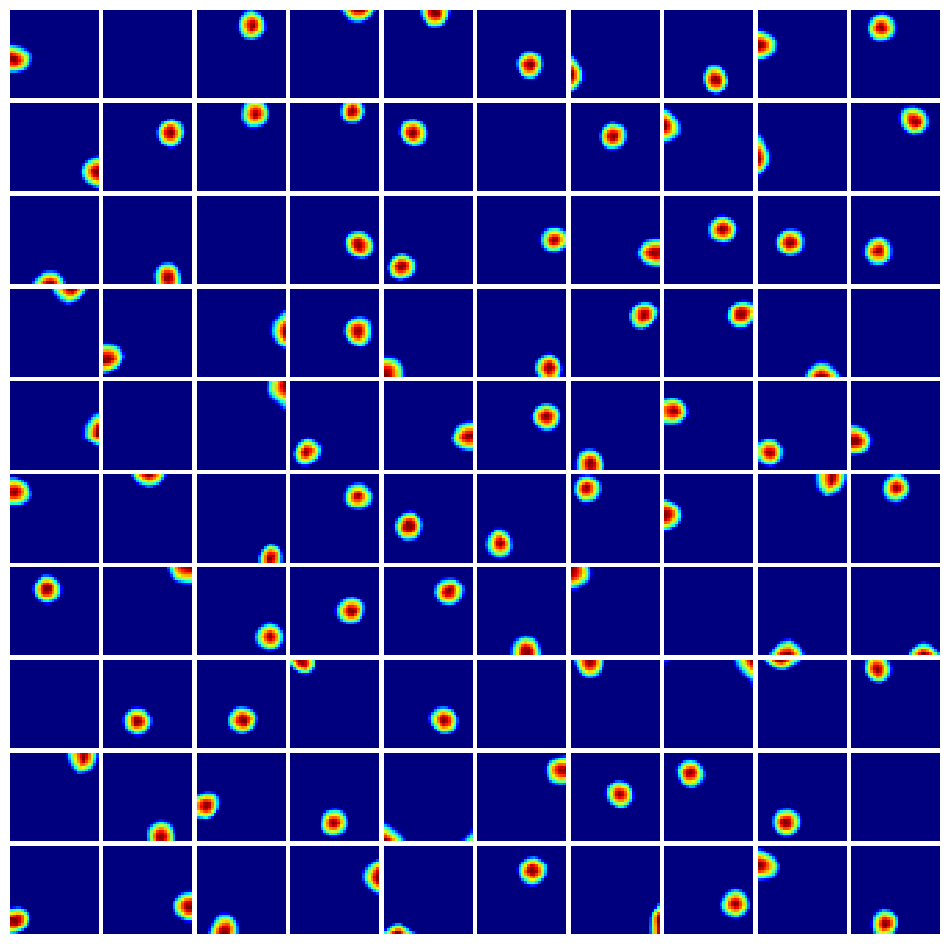

In [4]:
n_p = 10
fig, ax = plt.subplots(n_p, n_p, figsize =(12, 12))

for i, representation in enumerate(p.T[:n_p**2]):

    row = i // n_p
    col = i % n_p
    ax[row, col].axis("off")

    representation = representation.reshape(n, n)

    ax[row, col].imshow(representation, cmap = "jet", interpolation = "none")

plt.subplots_adjust(wspace=0.05, hspace=0.05)

In [5]:
relu = torch.nn.ReLU()
r0 = torch.nn.Parameter(torch.rand((n_out, n_out), dtype=torch.float32)*0.51)
R = lambda : relu(r0)

# create a torch optimizer
optimizer = torch.optim.Adam([r0], lr=1e-3)
losses = []
steps = 100000
# define a training loop
for _ in tqdm(range(steps)):
    optimizer.zero_grad()
    
    a = R().T@R() - torch.eye(len(r0)) # be orthogonal
    b = R()@R().T - torch.eye(len(r0)) # be orthogonal
    #c = torch.linalg.det(R()) - 1 # proper rotation

    loss = torch.mean(a**2)  + torch.mean(b**2) #+ torch.mean(c**2)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

plt.semilogy(losses)

 25%|██▌       | 25022/100000 [00:08<00:24, 3021.09it/s]


KeyboardInterrupt: 

In [6]:
w = R().detach().numpy()

In [7]:
np.linalg.det(w)

0.0

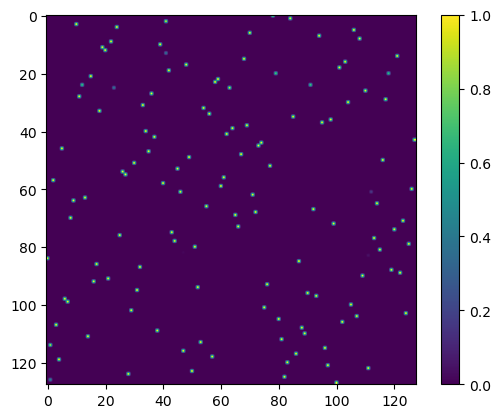

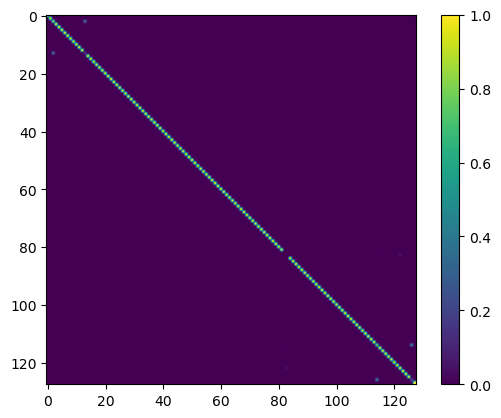

In [8]:
plt.imshow(w)
plt.colorbar()
plt.show()
plt.imshow(w@w.T)
plt.colorbar()
plt.show()

In [9]:
z = w@p.T

In [10]:
z.shape, p.shape, w.shape

((128, 1024), (1024, 128), (128, 128))

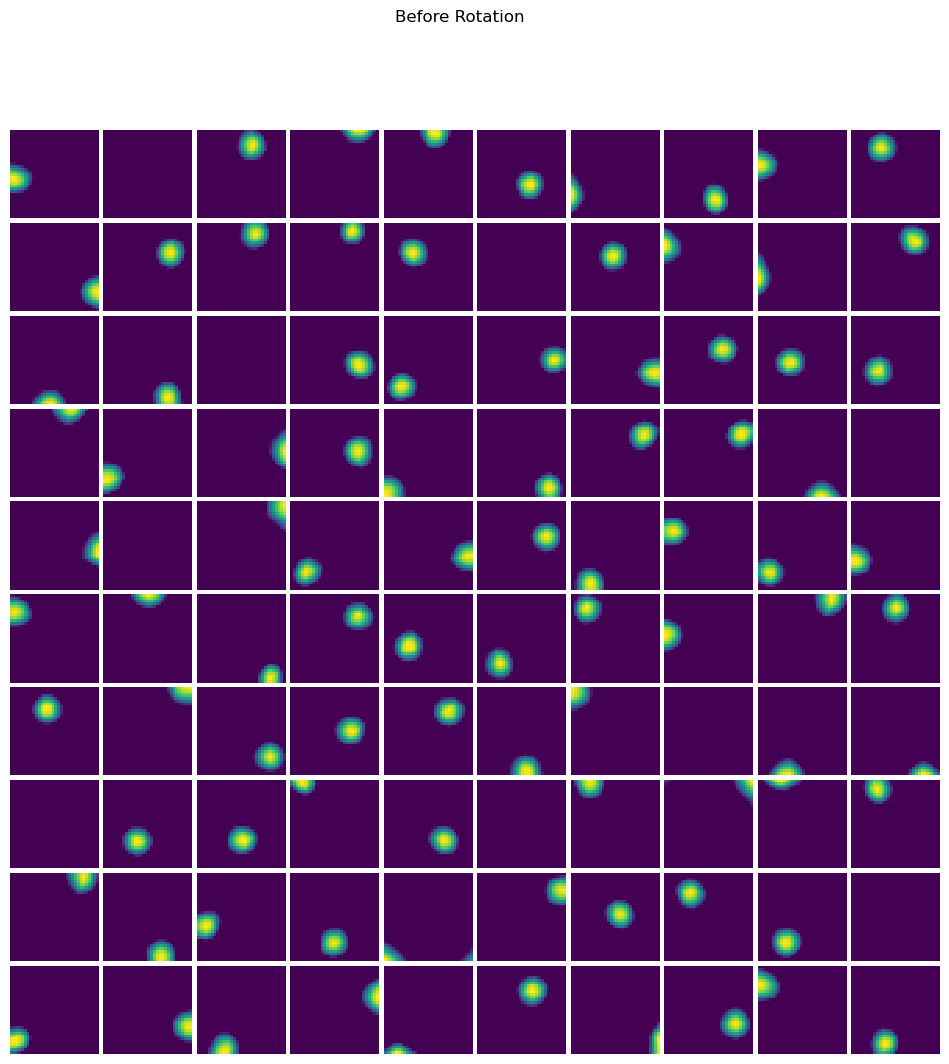

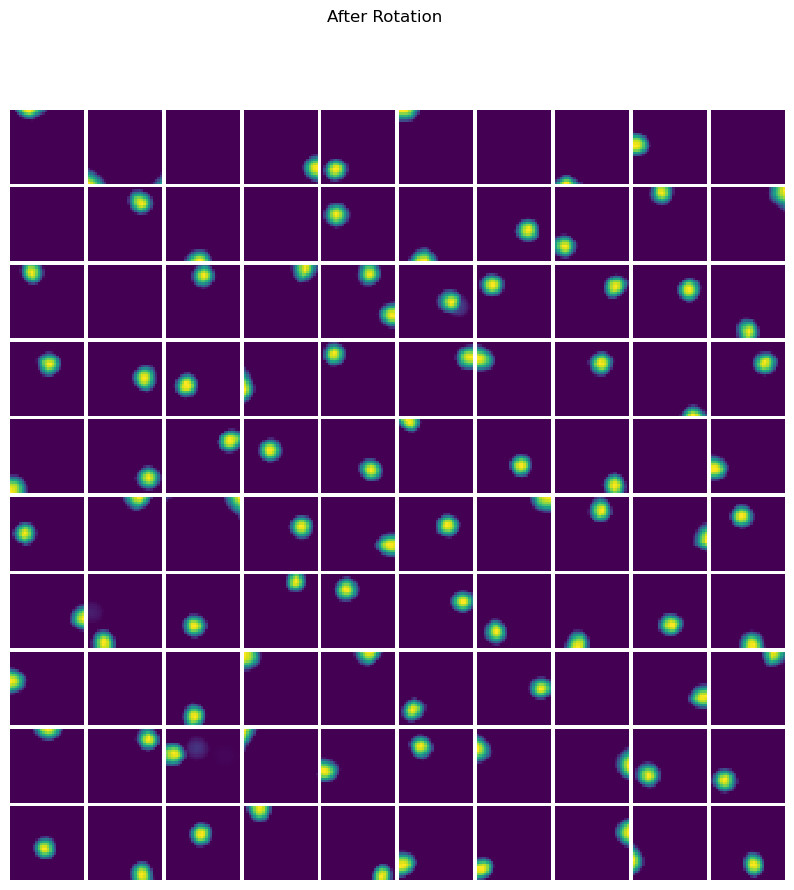

In [11]:
n_p = 10
fig, ax = plt.subplots(n_p, n_p, figsize =(12, 12))

for i, representation in enumerate(p.T[:n_p**2]):

    row = i // n_p
    col = i % n_p
    ax[row, col].axis("off")

    representation = representation.reshape(n, n)

    ax[row,  col].imshow(representation, interpolation = "none")

plt.suptitle("Before Rotation")
plt.subplots_adjust(wspace=0.05, hspace=0.05)

n_p = 10
fig, ax = plt.subplots(n_p, n_p, figsize =(10, 10))

for i, representation in enumerate(z[:n_p**2]):

    row = i // n_p
    col = i % n_p
    ax[row, col].axis("off")

    representation = representation.reshape(n, n)
    ax[row, col].imshow(representation, interpolation = "none")

plt.suptitle("After Rotation")
plt.subplots_adjust(wspace=0.05, hspace=0.05)

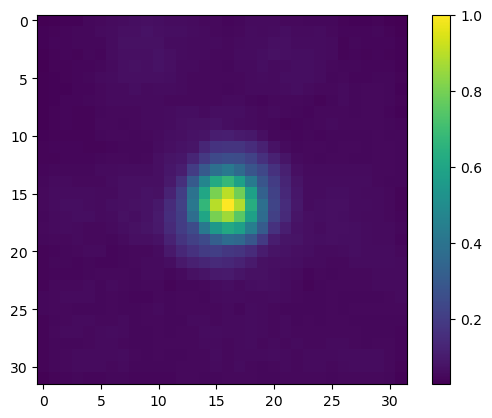

In [12]:
ps = z[:,512+16]
sim = np.exp(-np.sum((ps[None] - z.T)**2, axis = -1))
plt.imshow(sim.reshape(32,32), interpolation = "None")
plt.colorbar()

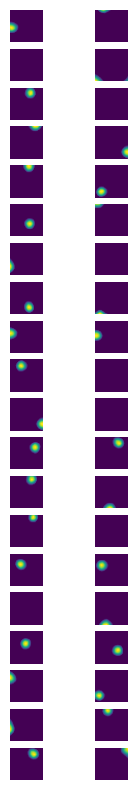

In [13]:
fig, ax = plt.subplots(20, 2, figsize = (2, 10))

for i in range(20):
    # ax[i,1].imshow(z[i].reshape(32,32),vmax = np.amax(p[:,i]))
    ax[i,1].imshow(z[i].reshape(32,32))#,vmax = np.amax(p[:,i]))

    ax[i, 0].imshow(p[:,i].reshape(32,32))
    ax[i,0].axis("off")
    ax[i,1].axis("off")

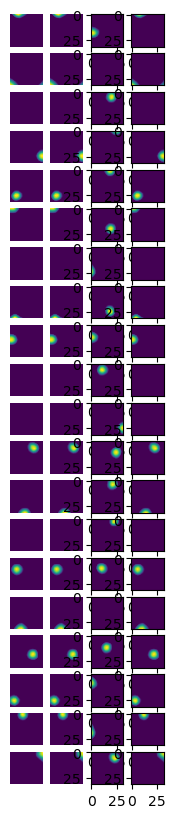

In [16]:
fig, ax = plt.subplots(20, 4, figsize = (2, 10))

for i in range(20):
    # ax[i,1].imshow(z[i].reshape(32,32),vmax = np.amax(p[:,i]))
    ax[i,1].imshow(z[i].reshape(32,32))#,vmax = np.amax(p[:,i]))
    ind = np.argmax(w[i])

    ax[i, 0].imshow(p[:,ind].reshape(32,32))
    ax[i, -2].imshow(p[:,i].reshape(32,32))
    ax[i, -1].imshow(p[:,ind].reshape(32,32))

    ax[i,0].axis("off")
    ax[i,1].axis("off")